# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from dcm import dcm

# Load Features

In [2]:
k = 5
strat = "dsp"

In [3]:
if strat == "kmer":
    data = pd.read_parquet(f'../../data/features/{k}-mer_standard.parquet')
elif strat == "chaos":
    data = pd.read_parquet('../../data/features/chaos_standard_128.parquet', engine='pyarrow')  # You can use 'fastparquet' as the engine
elif strat == "rtd":
    data = pd.read_parquet(f'../../data/features/{k}-rtd.parquet', engine='pyarrow')  # You can use 'fastparquet' as the engine
elif strat == "spaced":
    data = pd.read_parquet(f'../../data/features/{k}-spaced.parquet', engine='pyarrow')  # You can use 'fastparquet' as the engine
elif strat == "mash":
    data = pd.read_parquet('../../data/features/mash.parquet', engine='pyarrow')  # You can use 'fastparquet' as the engine
elif strat == "acs":
    data = pd.read_parquet('../../data/features/acs.parquet', engine='pyarrow')  # You can use 'fastparquet' as the engine
elif strat == "dsp":
    data = pd.read_parquet('../../data/features/dsp_real.parquet', engine='pyarrow')  # You can use 'fastparquet' as the engine

In [4]:
label_encoder = LabelEncoder()
data["Label"] = label_encoder.fit_transform(data["Target"])

X_train = data[data['Test'] == 0].drop(columns=["Target", "Test"])
X_test = data[data['Test'] == 1].drop(columns=["Target", "Test", "Label"])
y_test = data[data['Test'] == 1]['Label']
y_train = X_train['Label']
X_train = X_train.drop(columns=["Label"])

# Complexity Analysis

## Fisher's Score

In [5]:
index, F1 = dcm.F1(X_train.to_numpy(), y_train.to_numpy())
print(f"F1: {F1}")

KeyboardInterrupt: 

### 1 Nearest Neighbour

In [24]:
import pynndescent

import time

start = time.time()

accurate_index = pynndescent.NNDescent(
    X_train,
    n_neighbors=5,
    diversify_prob=0.0,
    pruning_degree_multiplier=2.0
)

end = time.time()

print(end-start)

closest_neighbors = accurate_index.neighbor_graph[0]

# Extract the indices of the points and their closest neighbors
point_indices = closest_neighbors[:, 0]
neighbor_indices = closest_neighbors[:, 1]

# Extract the classes for points and their closest neighbors
point_classes = y_train.iloc[point_indices].values if hasattr(y_train, 'iloc') else y_train[point_indices]
neighbor_classes = y_train.iloc[neighbor_indices].values if hasattr(y_train, 'iloc') else y_train[neighbor_indices]

# Calculate the accuracy as the proportion of classes that match
accuracy = np.mean(point_classes == neighbor_classes)

print(f"1 NN: {1-accuracy}")

20.304056882858276
1 NN: 0.5151601020119014


### Error Rate of Linear SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Initialize the LinearSVC model
# Set dual=False for n_samples > n_features to speed up the optimization
svm = LinearSVC(multi_class='ovr', verbose=1, max_iter=10)

# Fit the model to the training data
svm.fit(X_train, y_train)

# Predict the labels for the training data
y_pred = svm.predict(X_train)

# Calculate the accuracy
accuracy = accuracy_score(y_train, y_pred)

# Compute the error rate as 1 - accuracy
error_rate = 1 - accuracy

print(f"L2 Error Rate: {error_rate}")

### PCA Dimensionality

In [16]:
from sklearn.decomposition import PCA

# Initialize PCA with the first 1000 components
pca = PCA(n_components=1000)

# Fit PCA on the dataset
pca.fit(X_train)

# Calculate the cumulative sum of explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cumsum = np.cumsum(explained_variance_ratio)

# Find the number of components needed to represent 95% of the variability
m0 = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1  # +1 to account for the index starting at 0

print(f"Number of PCA components to represent 95% of variability (m0): {m0}")

Number of PCA components to represent 95% of variability (m0): 325


In [38]:
m0_ratio = m0/len(X_train.iloc[0])
m0_ratio

0.010924002554535982

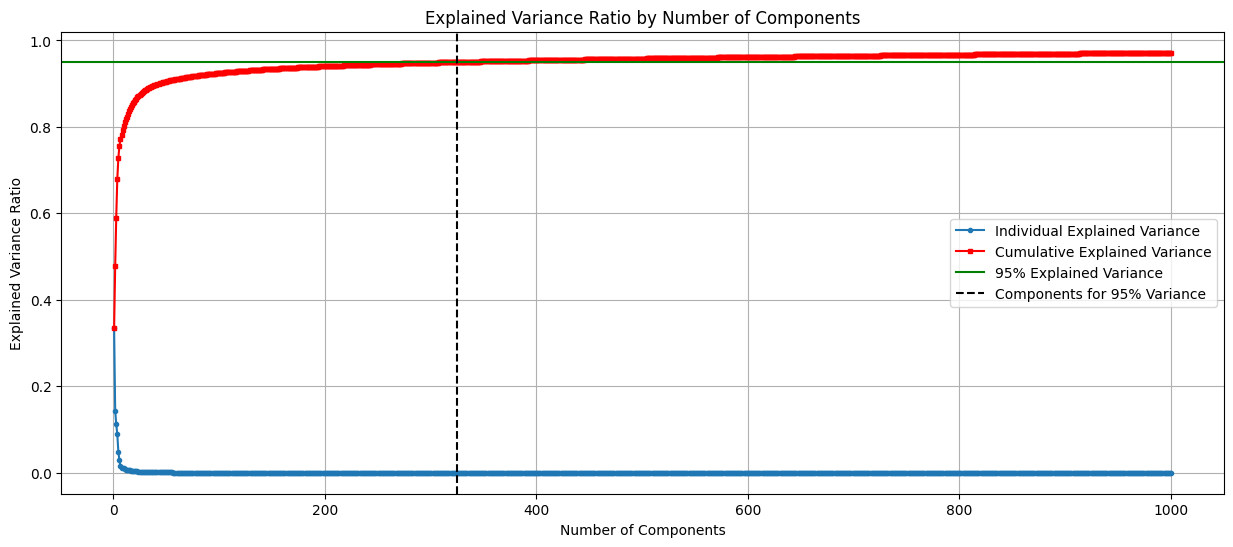

In [28]:
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual Explained Variance', markersize=3)
plt.plot(range(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='s', linestyle='-', color='red', label='Cumulative Explained Variance', markersize=3)
plt.title('Explained Variance Ratio by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.axhline(y=0.95, color='green', linestyle='-', label='95% Explained Variance')
plt.axvline(x=np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1, color='black', linestyle='--', label='Components for 95% Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [50]:
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)

In [51]:
X_train = X_train_transformed[:,:325]
X_test = X_test_transformed[:,:325]

In [52]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs = 15)

# Train the model using the training sets
rf.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = rf.predict(X_test)

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    7.6s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.5s finished


In [53]:
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

def split_labels(labels):
    # Split each label by '.' and return a list of lists
    return [label.split('.') for label in labels]

# Split the true and predicted decoded labels
true_labels_split = split_labels(y_test_decoded)
pred_labels_split = split_labels(y_pred_decoded)

max_depth = max(max(len(label) for label in true_labels_split), max(len(label) for label in pred_labels_split))

# Initialize lists to hold F1 scores for each level
f1_scores_micro = []
f1_scores_macro = []

# Calculate F1 scores for each hierarchical level
for level in range(max_depth):
    # Extract the specific level for all labels, using '' for missing levels
    true_level_labels = [label[level] if level < len(label) else '' for label in true_labels_split]
    pred_level_labels = [label[level] if level < len(label) else '' for label in pred_labels_split]
    
    # Calculate and store F1 scores for this level
    f1_micro = f1_score(true_level_labels, pred_level_labels, average='micro', zero_division=0)
    f1_macro = f1_score(true_level_labels, pred_level_labels, average='macro', zero_division=0)
    
    f1_scores_micro.append(f1_micro)
    f1_scores_macro.append(f1_macro)

f1_micro_global = f1_score(y_test, y_pred, average='micro')
f1_macro_global = f1_score(y_test, y_pred, average='macro')

# Append global F1 scores to the lists
f1_scores_micro.append(f1_micro_global)
f1_scores_macro.append(f1_macro_global)

# Define column names for the DataFrame
# Adding 1 to max_depth for the global scores
column_names = [f"Level {i} F1 Score (Micro)" for i in range(1, max_depth + 1)] + ["Global F1 Score (Micro)"]
column_names += [f"Level {i} F1 Score (Macro)" for i in range(1, max_depth + 1)] + ["Global F1 Score (Macro)"]

# Create a DataFrame with the F1 scores
# Since we only have one row of data, we use [f1_scores_micro + f1_scores_macro] to create a single-row DataFrame
df_results = pd.DataFrame([f1_scores_micro + f1_scores_macro], columns=column_names)
df_results

,Level 1 F1 Score (Micro),Level 2 F1 Score (Micro),Level 3 F1 Score (Micro),Level 4 F1 Score (Micro),Global F1 Score (Micro),Level 1 F1 Score (Macro),Level 2 F1 Score (Macro),Level 3 F1 Score (Macro),Level 4 F1 Score (Macro),Global F1 Score (Macro)
0,0.924274,0.797153,0.686171,0.798063,0.481006,0.433036,0.43019,0.402367,0.330841,0.28774


In [54]:
# Get unique values and their first occurrence indices
unique_values, indices = np.unique(y_test_decoded, return_index=True)

# Sort the indices to maintain the order of appearance
sorted_indices = np.sort(indices)

# Use sorted indices to get the unique values in the order they appear
labels = unique_values[np.argsort(indices)]

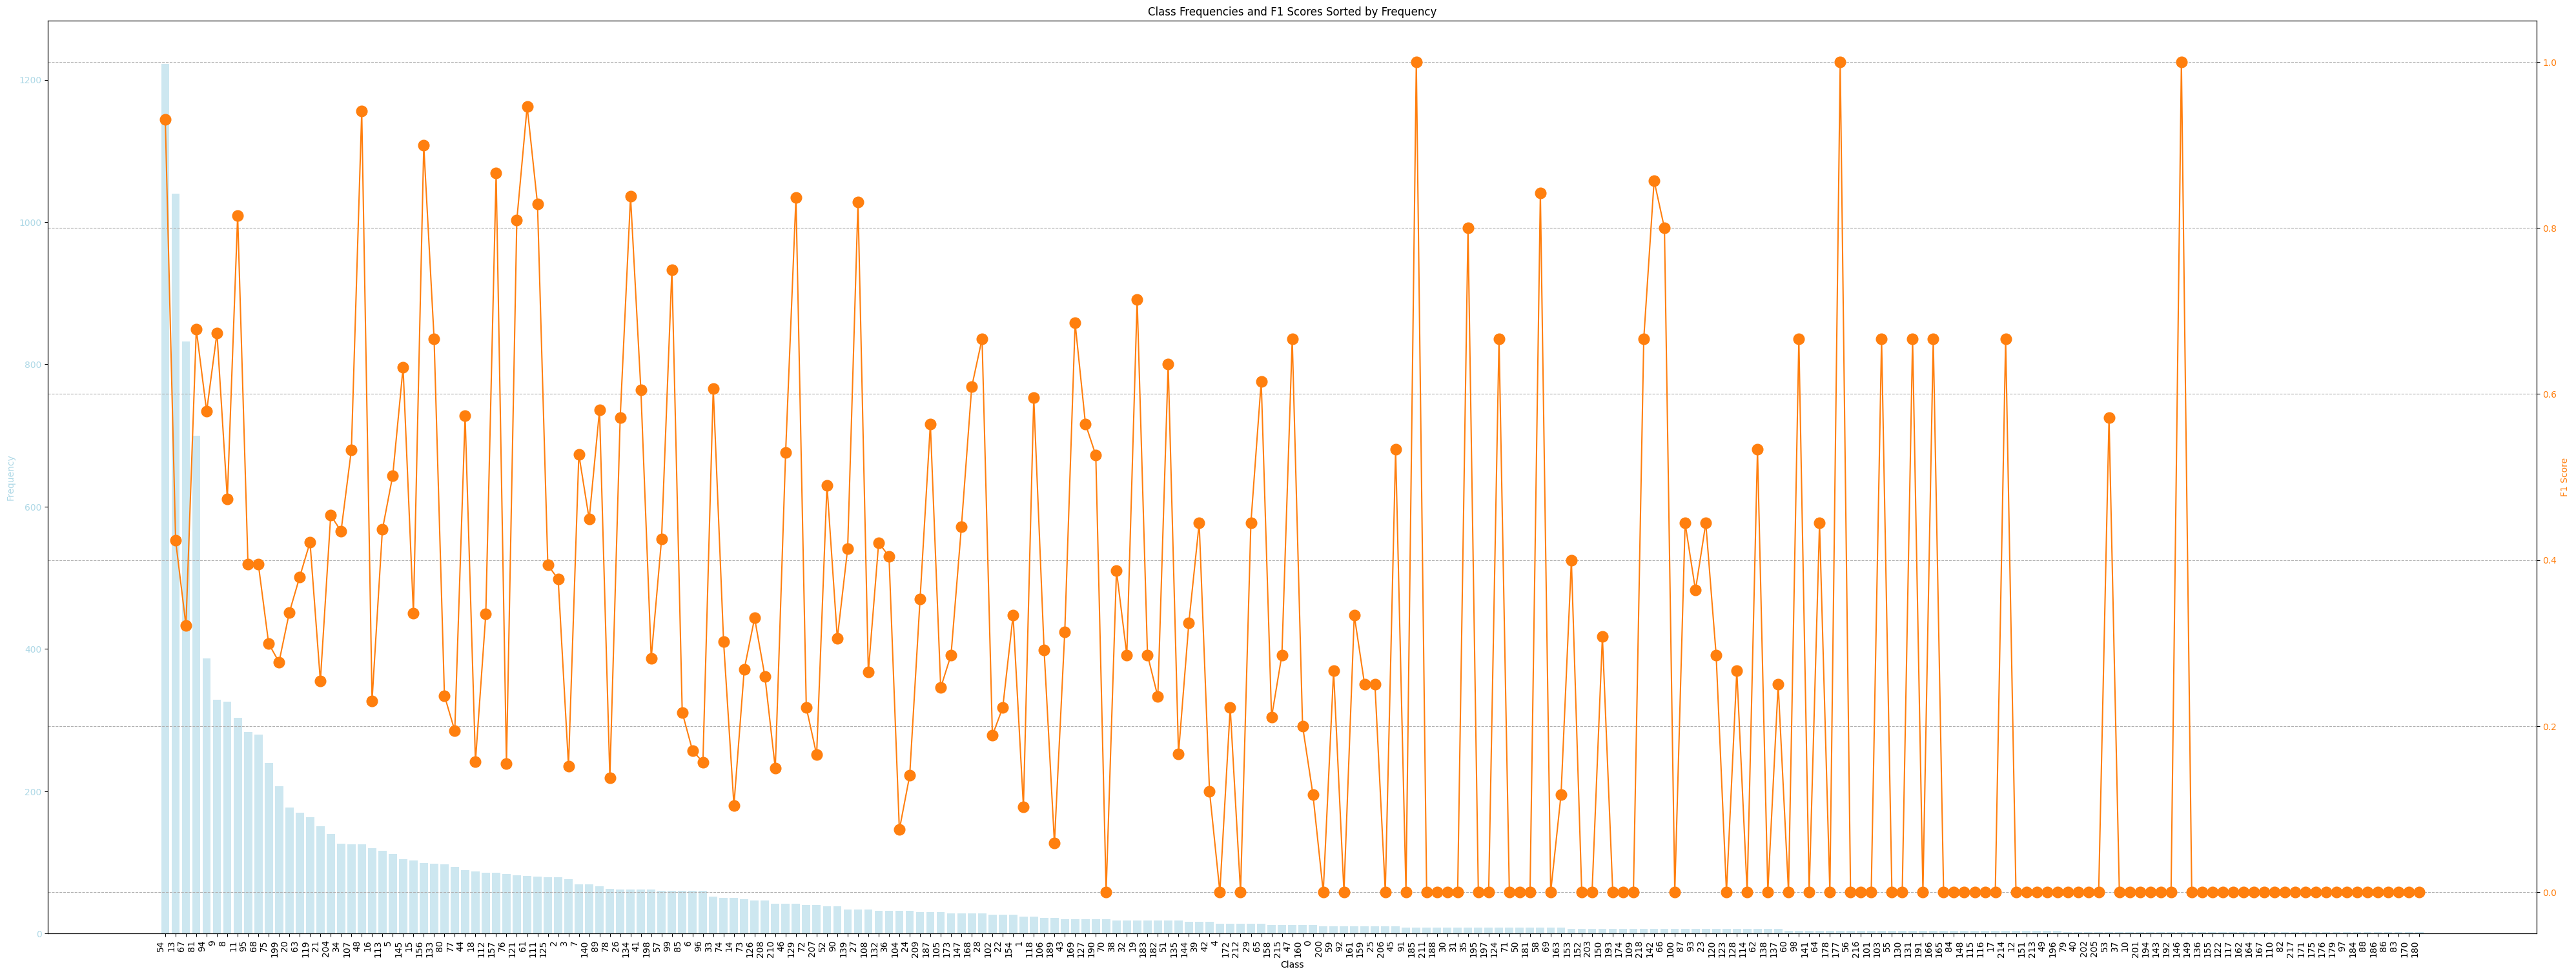

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from collections import Counter

classes, counts = np.unique(y_test, return_counts=True)
sorted_indices = np.argsort(-counts)  # Negative for descending order
sorted_classes = classes[sorted_indices]
sorted_counts = counts[sorted_indices]

# Compute F1 scores and sort according to the sorted classes
f1_scores = f1_score(y_test, y_pred, average=None, labels=classes)
sorted_f1_scores = f1_scores[sorted_indices]

# Plotting
fig, ax1 = plt.subplots(figsize=(40, 15))

# Bar plot for class frequencies
color = 'lightblue'
ax1.set_xlabel('Class')
ax1.set_ylabel('Frequency', color=color)
bars = ax1.bar(range(len(sorted_classes)), sorted_counts, color=color, alpha=0.6, label='Frequency')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(sorted_classes)))
ax1.set_xticklabels(sorted_classes, rotation=90, ha="right")

# Remove all grid lines for ax1 (Frequency axis)
ax1.grid(False)

# Instantiate a second y-axis for the F1 score
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('F1 Score', color=color)
line, = ax2.plot(range(len(sorted_classes)), sorted_f1_scores, color=color, marker='o', label='F1 Score', markersize=12)
ax2.tick_params(axis='y', labelcolor=color)

# Enable horizontal grid lines for F1 score axis only, disable vertical grid lines
ax2.grid(True, which='major', axis='y', linestyle='--')
ax2.grid(False, axis='x')  # Ensures no vertical grid lines are drawn

# Additional configurations
fig.tight_layout()
plt.title('Class Frequencies and F1 Scores Sorted by Frequency')
plt.show()